In [ ]:
import os

print(os.getcwd())

In [ ]:
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stemplot(title, data):
    markers,stems,base =  plt.stem(data, markerfmt=' ')
    
    p=plt.setp(stems, linestyle="-", color="blue", linewidth=0.1 )
#     plt.axis('off')
    plt.title(title+" - components' significance test for HC vs. PT")
    ax = plt.gca()
    ax.set_yticks([0, 5, 10])
    plt.savefig(title+' component_significance.svg', transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.savefig(title+' component_significance.pdf', format='pdf', dpi=600)
    plt.show()

# Some required functions

In [4]:
'''
THIS IS NOT FOR SALIENCY EVALUATION, ONLY FOR SALIENCY MAP, sFNC VISUALIZATIOON AND INTERPRETATION
Saliency Interpretation
Find the 5%-10%
Plot sFNC
Observe Patterns
'''

import sys
import time


import numpy as np
import torch
import tkinter
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# import seaborn as sb
import seaborn as sns

import datetime
import os
from scipy import stats

import pandas as pd

import random
import h5py
import time

from myscripts.LoadRealData import LoadABIDE, LoadCOBRE, LoadFBIRN, LoadOASIS
from myscripts.stitchWindows import stitch_windows
from datetime import datetime

from myscripts.roar_utils import rescale_two, rescale_input, compute_feature_ranking, random_feature_ranking, compute_feature_ranking_double_ended, weighted_feature_ranking_double_ended, compute_RAR_feature_ranking, random_perm_RAR_feature_ranking

from myscripts.interpretation_utilities import plot_dfnc, plot_average_dfnc, plot_pattern, plot_binary_mask, plot_avg_pattern, do_t_test

%matplotlib inline
  

ensembles = {0:'', 1:'smoothgrad', 2:'smoothgrad_sq', 3: 'vargrad', 4:'', 5:'smoothgrad', 6:'smoothgrad_sq', 7: 'vargrad'}

saliency_options = {0:'Grad', 1:'SGGrad', 2: 'SGSQGrad', 3: 'VGGrad', 4: 'IG', 5: 'SGIG', 6:'SGSQIG', 7:'VGIG', 8: 'DLift', 9: 'DLiftShap', 10: 'ShapValSample', 11: 'ShapVal', 12: 'lime'}


start_time = time.time()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def do_sFNC_t_test(x_HC, x_PT):
    
    t_values = np.zeros((53, 53))
    p_values = np.zeros((53, 53))
    final1 = np.zeros((53, 53))
    final2 = np.zeros((53, 53))
    
    
    for i in range(53):  # For 53 ica components
        
        
        '''it computes the t-statistic and then compares against the critical t-value which is computed internally.
        With this it gets the value of p. If it is low enough <=0.0005, it means we can reject the null hypothesis, 
        which in turn implies that the distributions are statistically different'''
        
        for j in range(53):
            
            a = x_HC[:, i, j]
            b = x_PT[:, i, j]


            ## Cross Checking with the internal scipy function
            t2, p2 = stats.ttest_ind(b, a)

            t_values[i, j], p_values[i, j] = t2, p2
       
            final1[i, j] = t_values[i, j] if p_values[i, j] < 0.05 else 0
            final2[i, j] = t_values[i, j] if p_values[i, j] < 0.05/1378 else 0
    
    return t_values, final1, final2

def fnc_plot(M, title, clim=(-1,1)):
    
    np.fill_diagonal(M, 0)
    p1= plt.imshow(M, interpolation=None, clim=clim,
               cmap=plt.cm.seismic)
    ax = plt.gca()
    plt.title(title)
    
    plt.colorbar()
    # Minor ticks
    groups = [-0.5, 4.5, 6.5, 15.5, 24.5, 41.5, 48.5, 52.5]
    ax.set_xticks(groups, minor=True)
    ax.set_yticks(groups, minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
    # Major ticks
    group_centers = [2, 5.5, 11, 20, 33, 45, 50.5]
    ax.set_xticks(group_centers)
    ax.set_yticks(group_centers)

    # Labels for major ticks
    labels = ['SC', 'AU', 'SM', 'VI', 'CC', 'DM', 'CB']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=90, fontdict={'verticalalignment': 'center'})
    ax.tick_params(axis='both', which='major', length=0)
    #ax.set_frame_on(False)
    
    plt.savefig(title+'.svg', transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

    
    
def find_indices_of_each_class(all_labels):
    HC_index = (all_labels == 0).nonzero()
    SZ_index = (all_labels == 1).nonzero()

    return HC_index, SZ_index

def ReLU(x):
    print("Greetings from ReLU")
    return x * (x >= 0)

def dFNC(data):
       
    M = np.corrcoef(data) 
    M = np.nan_to_num(M)
      
    return M 

def calculateFNC(data):
    
    FNC = np.zeros((data.shape[0], 1378))
    corrM = np.zeros((data.shape[0], components, components))
    for k in range(data.shape[0]):
        corrM[k, :, :] = np.corrcoef(data[k])
        M = corrM[k, :, :]
#         print("Count Before: ", np.count_nonzero(np.isnan(M)))
        M = np.nan_to_num(M)
        FNC[k, :] = M[np.triu_indices(53, k=1)]
        corrM[k, :, :]= M
#         print("Count After: ", np.count_nonzero(np.isnan(FNC[k, :])))
    return FNC, corrM 

# Normalize and Calculate EMD distance

In [2]:
def normalize(a):
    return np.asarray(a)/np.sum(a)

def emd(a, b):
    assert len(a) == len(b), "Sequences should be same length!"
    a = normalize(a)
    b = normalize(b)

    return np.sum(np.abs(np.cumsum(a - b)))

# Original Code I started with

Welcome to ABIDE Analysis
(569, 14000)
Reshape we need: (569, 100, 140)
/data/users2/mrahman21/My_Project/baselines/pytorch-a2c-ppo-acktr-gail/STDIM_fMRI/ABIDE/correct_indices_GSP.csv
Reshape we finalized: (569, 53, 140)
(569, 1378)
Final Data Shape: (569, 53, 140)
FNC shape: (569, 1378)
Length of HC: 255
Length of SZ: 314
HC_index: torch.Size([255, 1])
SZ_index: torch.Size([314, 1])
HC_index: torch.Size([255])
/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/OASIS_FNC
transform_to_correct_GSP.csv
/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Best Gain Chosen: [0.4, 0.6, 0.5, 0.5, 0.3, 1.2]
Basic loading Done...
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_0.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


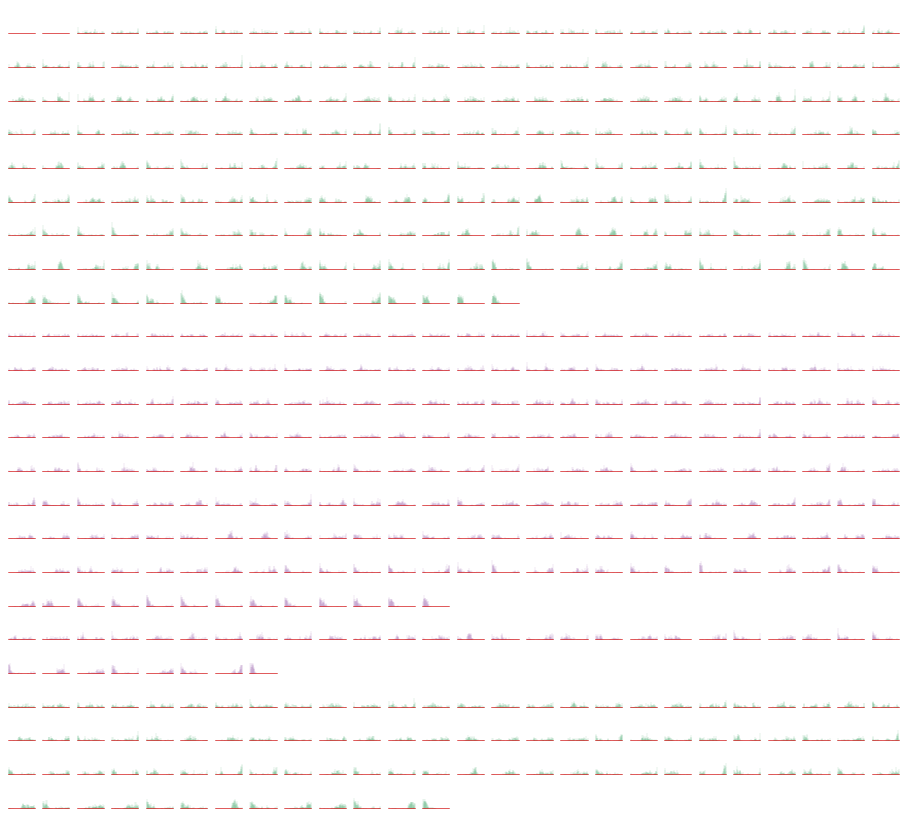

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_1.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


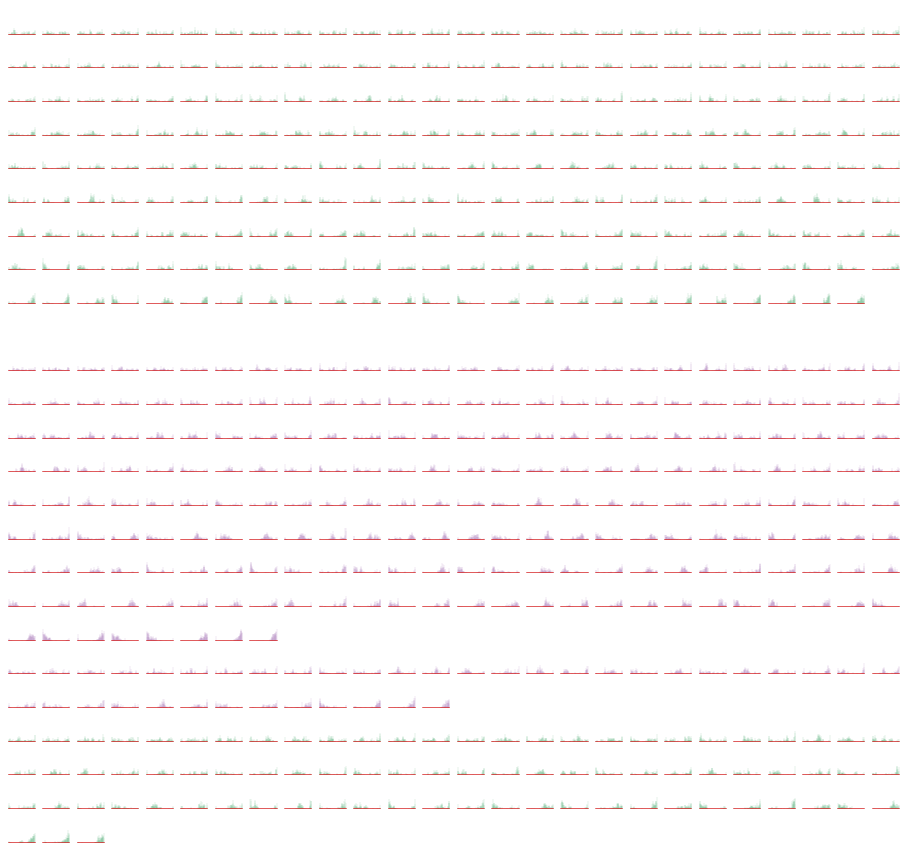

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_2.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


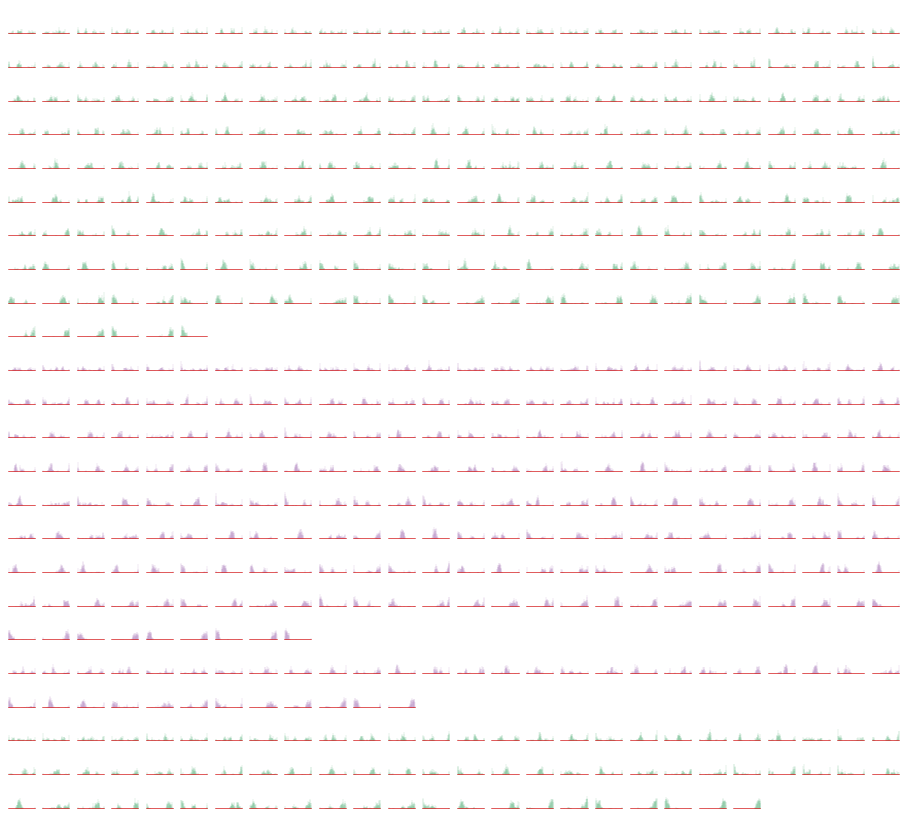

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_3.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


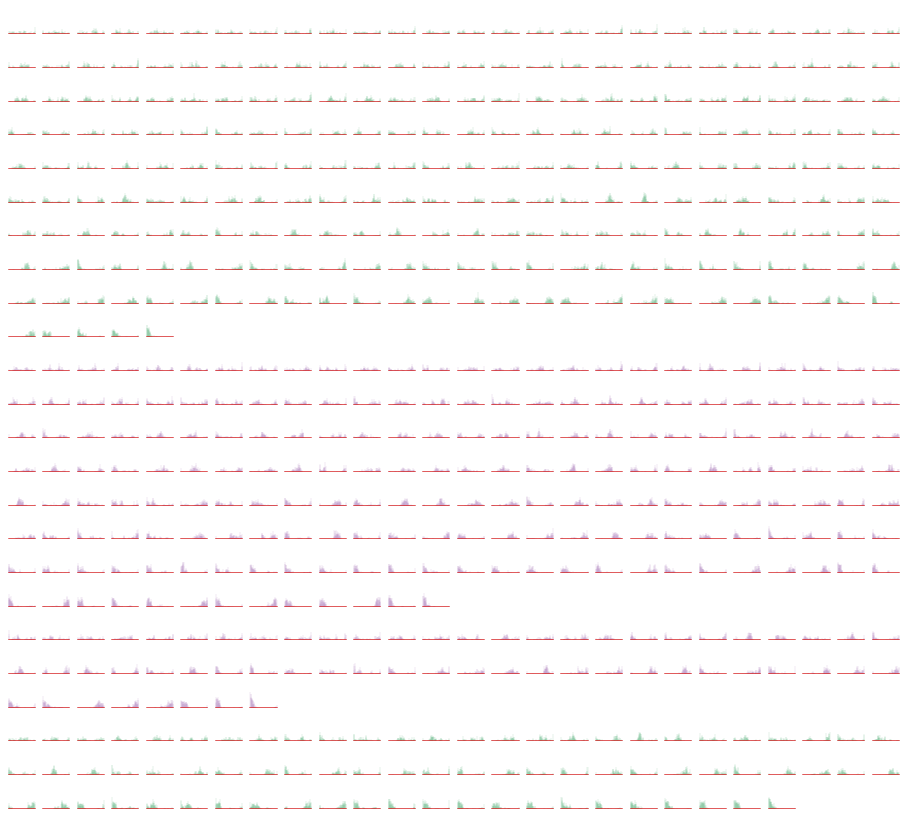

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_4.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


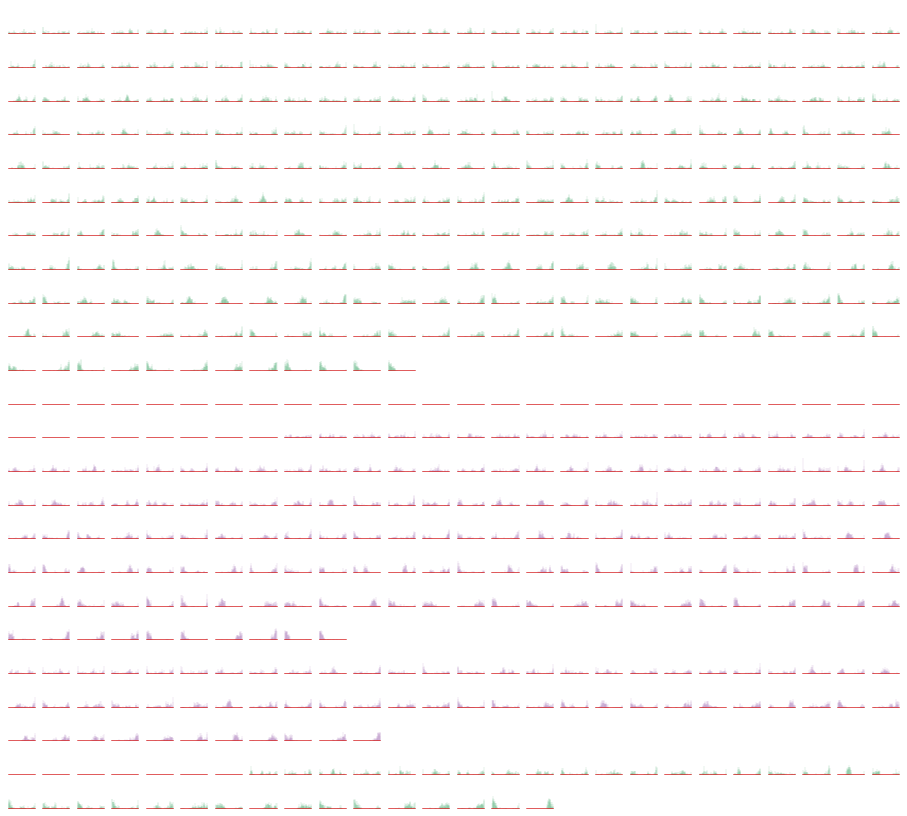

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_5.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


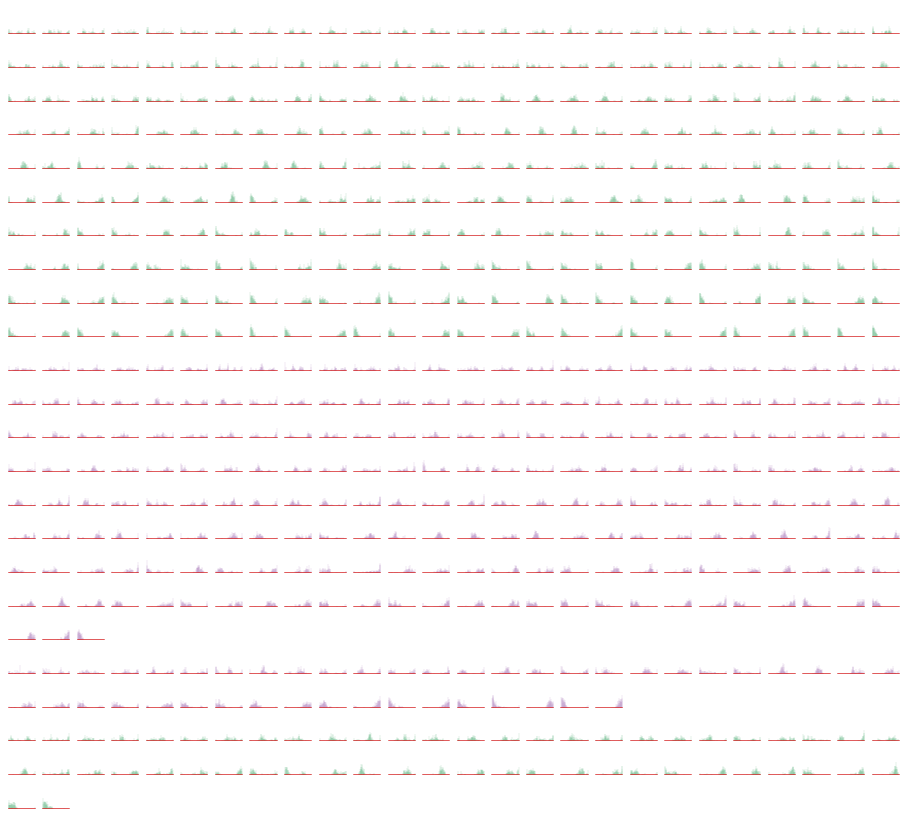

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_6.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


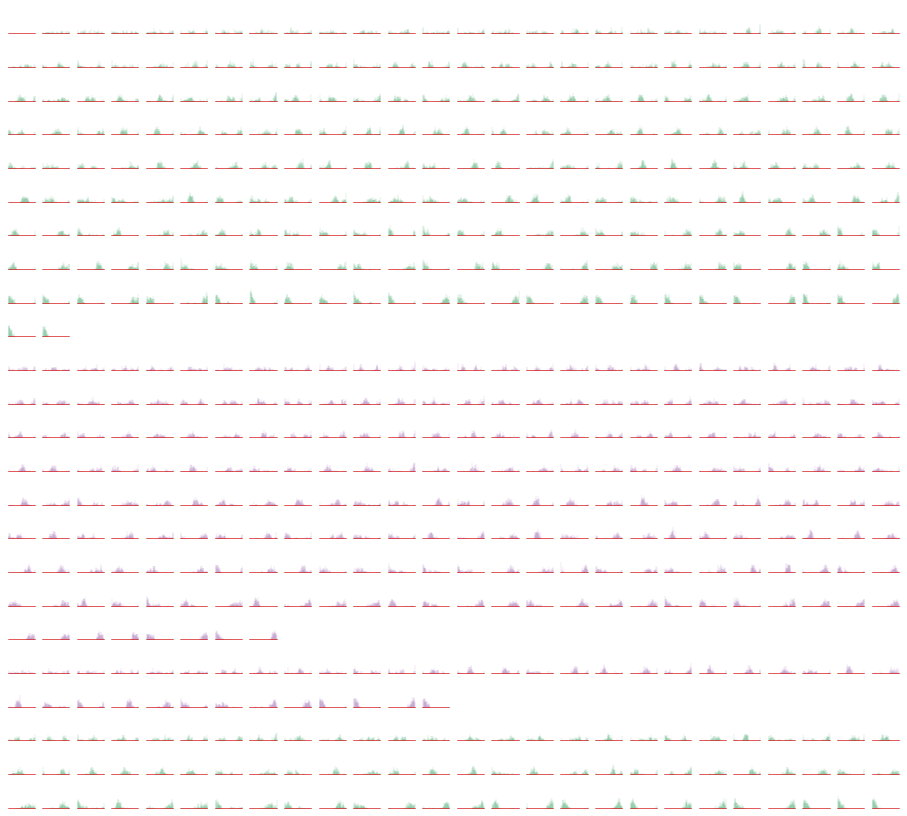

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_7.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


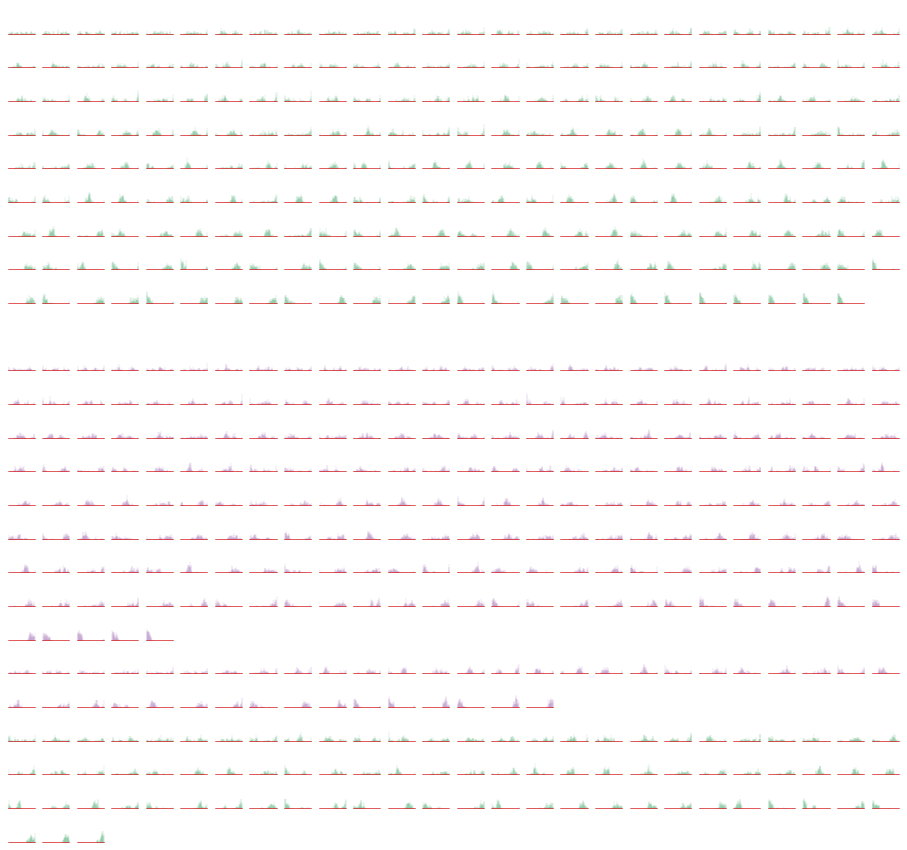

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_8.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


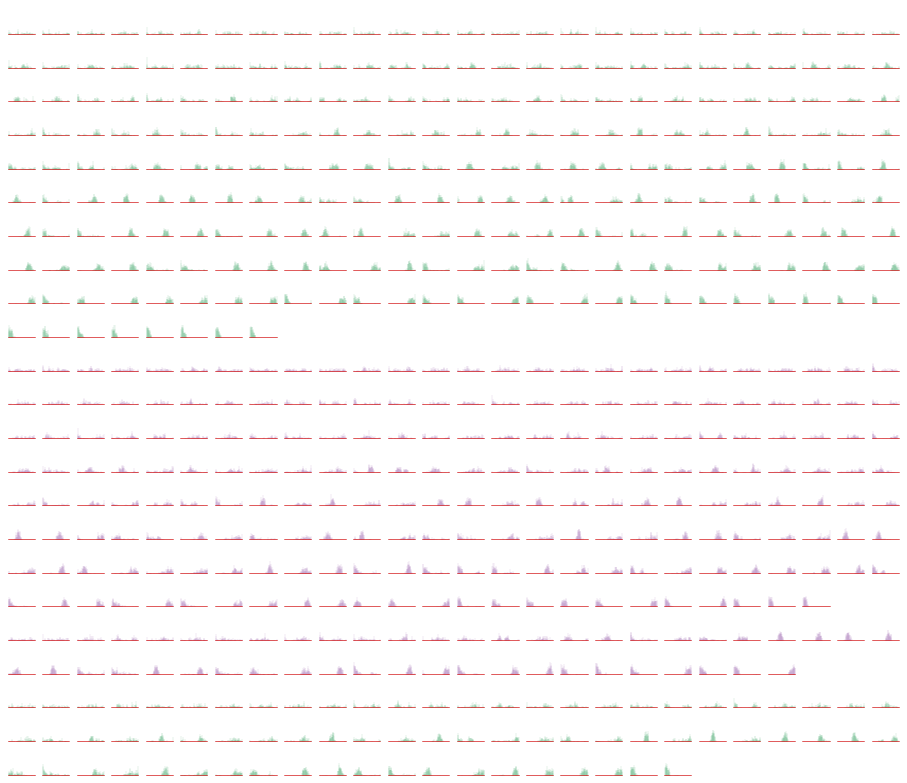

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_9.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)


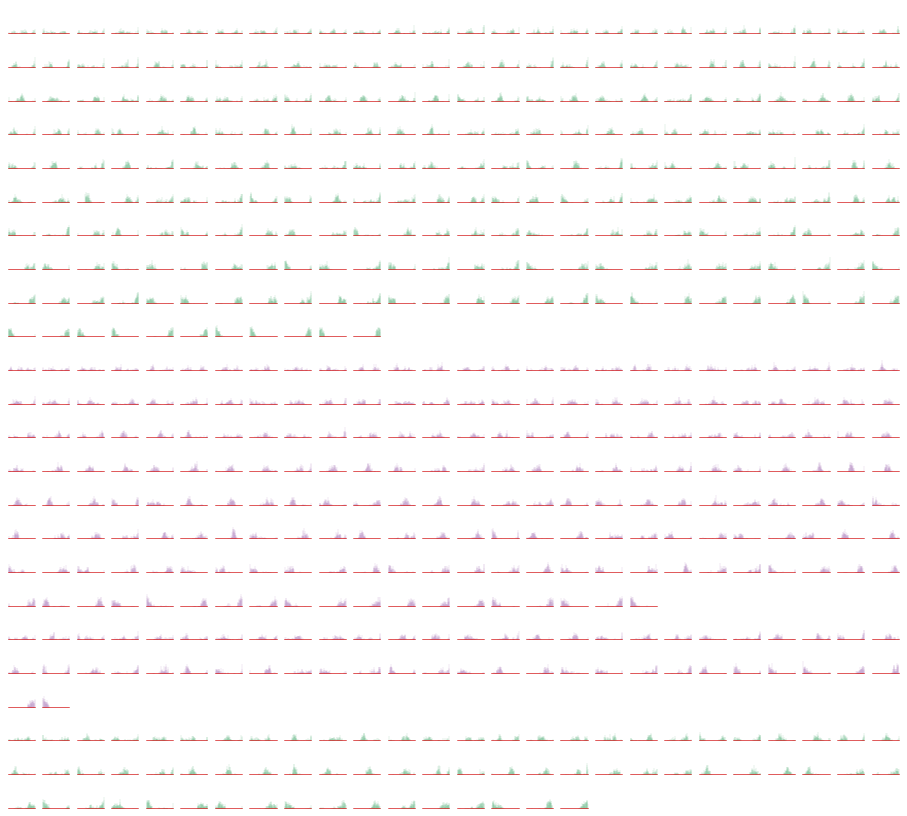

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC
Total Time Elapsed: 12056.216921806335
2021-09-15 14:44:38.380878


In [29]:
MODELS = {0: 'FPT', 1: 'UFPT', 2: 'NPT'}

Dataset = {0: 'FBIRN', 1: 'COBRE', 2: 'OASIS', 3: 'ABIDE'}
Directories = { 'COBRE': 'COBRESaliencies','FBIRN' : 'FBIRNSaliencies', 'ABIDE' : 'ABIDESaliencies','OASIS' : 'OASISSaliencies'}

FNCDict = {"FBIRN": LoadFBIRN, "COBRE": LoadCOBRE, "OASIS": LoadOASIS, "ABIDE": LoadABIDE}

Params = {'FBIRN':[311, 140, 121], 'COBRE': [157, 140, 121], 'OASIS': [372, 120, 101], 'ABIDE': [569, 140, 121]}
train_lim = { 'FBIRN': 250, 'COBRE': 100, 'OASIS': 300, 'ABIDE': 400}

Params_subj_distr = { 'FBIRN': [15, 25, 50, 75, 100], 'COBRE': [15, 25, 40], 'OASIS': [15, 25, 50, 75, 100, 120], 'ABIDE': [15, 25, 50, 75, 100, 150]}

test_lim_per_class = { 'FBIRN': 32, 'COBRE': 15, 'OASIS': 32, 'ABIDE': 50}

# These gains were based on cross-validation based search

# Params_best_gains = {1: {'FBIRN': {'NPT':[1.0, 0.9, 0.9, 1.0, 1.0], 'UFPT': [1.0, 0.8, 0.7, 0.5, 0.4]}, 'OASIS': {'NPT': [0.9, 0.9, 1.0, 1.1, 1.1, 1.0], 'UFPT': [0.8, 0.8, 0.4, 0.3, 0.5, 0.4]}, 'ABIDE': {'NPT': [1.0, 0.9, 0.9, 1.0, 0.7, 0.6], 'UFPT': [0.4, 0.8, 0.3, 0.2, 0.2, 0.1]}, 'COBRE': {'NPT': [1.1, 0.7, 0.8], 'UFPT': [1.6, 1.3, 1.3]}}, 
#                      10: {'COBRE': {'NPT': [0.9, 0.9, 1.0], 'UFPT': [1.2, 1.2, 1.4]}},
#                      20: {'COBRE': {'NPT': [1.5, 0.8, 0.8], 'UFPT': [1.2, 1.3, 1.3]}}  
#                     }

# Revised h_fixed Simiple Gain Selection

Params_best_gains = {1: {'FBIRN': {'NPT':[1.2, 1.3, 0.7, 1.1, 0.9], 'UFPT': [0.9, 0.7, 0.6, 0.5, 0.4]}, 'ABIDE': {'NPT': [1.3, 1.3, 1.1, 0.9, 1.3, 0.6], 'UFPT': [0.4, 0.6, 0.5, 0.5, 0.3, 1.2]}, 'OASIS': {'NPT': [0.1, 1.2, 1.0, 1.0, 1.2, 0.7], 'UFPT': [0.7, 0.7, 1.3, 0.6, 1.1, 1.2]},'COBRE': {'NPT': [0.9, 0.9, 1.0], 'UFPT': [0.4, 1.1, 1.3]}}, 20: {'COBRE': {'NPT': [0.6, 1.1, 1.1], 'UFPT': [1.1, 1.5, 0.6]}}}

mode = 1  # Choose FPT (0) / UFPT (1) / NPT (2)
data= 3  # Choose FBIRN (0)/ COBRE (1) / OASIS (2) / ABIDE (3)

saliency_id = 5 #int(sys.argv[1]) 

finalData, FNC, all_labels = FNCDict[Dataset[data]]()

print('Final Data Shape:', finalData.shape)
print('FNC shape:', FNC.shape)

HC_index, SZ_index = find_indices_of_each_class(all_labels)

print('Length of HC:', len(HC_index))
print('Length of SZ:', len(SZ_index))

print('HC_index:', HC_index.shape)
print('SZ_index:', SZ_index.shape)

HC_index = np.squeeze(HC_index, axis = 1)
SZ_index = np.squeeze(SZ_index, axis = 1)
print('HC_index:', HC_index.shape)


components = finalData.shape[1]
sample_y = 20
subjects = Params[Dataset[data]][0]
time_points = Params[Dataset[data]][1]
samples_per_subject = Params[Dataset[data]][2]
window_shift = 1


dir = MODELS[mode]   # NPT or UFPT

GAIN = {1:0.1, 2:0.2, 3:0.3, 4:0.4, 5:0.5, 6:0.6, 7:0.7, 8:0.8, 9:0.9, 10:1.0, 11:1.1, 12:1.2, 13:1.3, 14:1.4, 15:1.5, 16:1.6, 17:1.7, 18:1.8, 19:1.9, 20:2.0} 

print(os.getcwd())
root_path = "/data/users2/mrahman21/Saliency/myscripts"
os.chdir(root_path)

filename = 'transform_to_correct_GSP.csv'
print(filename)
df = pd.read_csv(filename, header=None)
c_indices = df.values
c_indices = c_indices - 1
# c_indices = torch.from_numpy(c_indices).int()
comp_indices = c_indices[:, 2]  # Third column in the file contains the transformation indices...
# comp_indices = comp_indices.int()


run_dir = "../wandb/Classic_ML_Models/"+Dataset[data]+"_FNC"


os.chdir(run_dir)   # Dynamically change the current directory during run time.
print(os.getcwd())

sbpath = os.path.join('../../', 'Sequence_Based_Models')
basename = os.path.join(sbpath, Directories[Dataset[data]], dir, 'Saliency')

Trials = 10
np.random.seed(0)

models = ["MLP", "LinearSVM", "SVM", "LR"]

subjects_per_group = Params_subj_distr[Dataset[data]] 

Best_gain = Params_best_gains[window_shift][Dataset[data]][MODELS[mode]]
print('Best Gain Chosen:', Best_gain)


finalData = torch.from_numpy(finalData).float()

Fraction = [0.05] #[0.05, 0.1, 0.2, 0.3] 


i = len(subjects_per_group) - 1
g = Best_gain[i]

last_test_fold_id = {'FBIRN': 4, 'OASIS': 5, 'ABIDE': 4}
test_ID = last_test_fold_id[Dataset[data]]

# prefix = Dataset[data]+'_spc_'+str(subjects_per_group[i])+'_cross_val_gain_'+str(g)+'_'+dir+'_LSTM_milc'

# prefix= f'{Dataset[data]}_spc_{subjects_per_group[i]}_simple_gain_{g}_window_shift_{window_shift}_{dir}_stab_sig_rmv_chk_h_test_id_{test_ID}_LSTM_milc'

prefix= f'{Dataset[data]}_spc_{subjects_per_group[i]}_simple_gain_{g}_window_shift_{window_shift}_{dir}_stab_chk_h_test_id_{test_ID}_LSTM_milc'

# prefix= f'{Dataset[data]}_spc_{subjects_per_group[i]}_simple_gain_{g}_window_shift_{window_shift}_{dir}_arch_chk_h_fixed_test_id_{test_ID}_LSTM_milc'

# prefix= f'{Dataset[data]}_spc_{subjects_per_group[i]}_cross_val_gain_{g}_window_shift_{window_shift}_{dir}_LSTM_milc'
# prefix = Dataset[data]+'_fold_'+str(fold)+'_gain_'+str(g)+'_NPT_LSTM_milc_prediction'


Labels = all_labels.numpy()

print("Basic loading Done...")

for saliency_id in [5]:

    dissimilar_components = np.zeros((10, 53))

#     fig=plt.figure(figsize=(16,16))

    # all_seeds_temp_distributions = {}

    all_seeds_temp_distributions = np.zeros((finalData.shape[0], 10, finalData.shape[2]))

    for restart in range(Trials):  # Trials

        predictions_file = os.path.join(basename, prefix+'_labels_save_'+str(restart)+'.npy')
#         scores_file = os.path.join(basename, prefix+'_scores_save_'+str(restart)+'.npy')
#         scores = np.load(scores_file)
#         print("Scores Shape:", scores.shape)
        predictions = np.load(predictions_file)

        print("Predictions Shape:", predictions.shape)

    #     filename1 = os.path.join(basename, prefix+'_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')
        filename1 = os.path.join(basename, prefix+'_chk_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')


        print('Loaded saliency from...', filename1)
        Map1 = np.load(filename1)
        print(Map1.shape)


        Map1 = stitch_windows(Map1, components, samples_per_subject, sample_y, time_points, ws=window_shift)
        print('Average Shape:', Map1.shape)


    #     It ensures that while creating feature_ranking mask, the zero values will be treated separately 

        epsilon = 0.000000001
        Map1[Map1 == 0] = Map1[Map1 == 0] + epsilon

        sal_map = Map1 / np.max(Map1)
        sal_map = torch.from_numpy(sal_map).float()


        Map1 = torch.from_numpy(Map1).float()

        for f in range(len(Fraction)):

        # Remove data based on feature ranking and receive the updated data 

            Data = np.zeros(finalData.shape)
            feature_rank = np.zeros(finalData.shape)

            data_mask = np.zeros(finalData.shape)

            component_counter = np.zeros((finalData.shape[0], 53))

            # For revised data for saliency interpretation

            dCorrM1 = np.zeros((finalData.shape[0], 53, 53))  # Dynamic correlation matrices for all subjects. 
            dCorrM2 = np.zeros((finalData.shape[0], 53, 53))  # Dynamic correlation matrices for all subjects. 

            TP, TN, FP, FN = [], [], [], []

            fig=plt.figure(figsize=(16,16))

            for t in range(Map1.shape[0]):
                
#                 if len(np.unique(Map1[t])) == 1:
#                     Map1[t] = 1.0/(Map1[t].shape[0]*Map1[t].shape[1])
                
                Data[t], feature_rank[t] = compute_RAR_feature_ranking(finalData[t], Map1[t], Fraction[f])
                
                Data[t] = Data[t]/np.max(Data[t])

                result = np.where(Data[t] != 0.0)

                times = np.unique(result[1])  # Working on important time steps

                data_mask[t][feature_rank[t] !=0] = 1 
                feature_rank[t][feature_rank[t] !=0] = 1

                component_counter[t, :] = np.sum(data_mask[t], axis=1)
                component_counter[t] = component_counter[t, comp_indices]

                map_to_fnc = Map1[t, comp_indices, :]*data_mask[t, comp_indices, :]

                map_to_fnc = map_to_fnc / torch.max(map_to_fnc)
                Data[t] = Data[t, comp_indices, :]
                data_mask[t] = data_mask[t, comp_indices, :]
                prod = (torch.from_numpy(Data[t]).float())*map_to_fnc
                data_imp_temp = Data[t][:, times]      # RAR 5%
    #             dCorrM1[t, :, :] = dFNC(data_imp_temp)
                all_seeds_temp_distributions[t, restart, :] = np.sum(data_mask[t],0)
                
                if len(np.unique(Map1[t])) == 1:
                    temporal_count = np.array([1.0/Map1[t].shape[1]]*Map1[t].shape[1])
                else:
                    temporal_count = np.sum(data_mask[t],0)
                    
                if int(Labels[t]) == int(predictions[t, 1]):

                    if int(Labels[t]) == 0:
                        TN.append(temporal_count)
                    else:
                        TP.append(temporal_count)

                else:
                    if int(Labels[t]) == 0:
                        FP.append(temporal_count)
                    else:
                        FN.append(temporal_count)
    
            plot_dim = int(np.ceil(np.sqrt(finalData.shape[0]))) + 2

              
#b2182b - HC
#ef8a62 - PT, "RdBu", "seismic"
            counter = 1
            
            # Plot original saliency based on original order
    
#             for i in range(Map1.shape[0]): # sort_by_locations:

#                 ax = plt.subplot(plot_dim, plot_dim , counter)
#                 if i in range(Map1.shape[0]): 
        
#                     if int(Labels[i]) == 0:
#                         ax.imshow(data_mask[i], interpolation='nearest', aspect='auto', cmap= "Reds")
# #                         ax.set_title(str(int(i))+"/"+str(int(Labels[i]))+"/"+str(int(predictions[i, 1]))+" "+np.array2string(scores[i]), fontsize='x-small', y=1.0, pad=4)
#                     else:
#                         ax.imshow(data_mask[i], interpolation='nearest', aspect='auto', cmap= "cool") 
#                     ax.set_title(str(int(i))+"/"+str(int(Labels[i]))+"/"+str(int(predictions[i, 1])), fontsize='x-small', y=1.0, pad=4)

#                 counter += 1
#                 plt.axis('off')
            
#             plt.subplots_adjust(bottom=0.01, top=0.99, wspace=0.05)

#             # Plots 5% saliency mask temporal based on model behaviour
                
            my_dict = {"TP" : TP, "TN": TN, "FP": FP, "FN": FN}
            dict_to_save = {}
        
            template = np.array([1.0/140]*140)
            

            for k, v in my_dict.items():
                group = v
                if (counter - 1) % plot_dim != 0:
                    counter = counter + plot_dim - counter % plot_dim + 1
#                 peak_locations = [np.argsort(x)[-1] for x in group]
#                 sort_by_locations = np.argsort(peak_locations)
                
                x_interp = np.linspace(1, finalData.shape[2], 140)
                xp = np.linspace(1, finalData.shape[2], finalData.shape[2])
                new_group = [np.interp(x_interp, xp, fp) for fp in group]
                emd_distances = [emd(x, template) for x in new_group]
                sort_by_locations = np.argsort(emd_distances)
                
                new_order = []
                
                for i in sort_by_locations:

                    ax = plt.subplot(plot_dim, plot_dim, counter)
                    ax.set_ylim([0, 55])    
                        
                    markers,stems,base =  ax.stem(v[i], markerfmt=' ')
#                     print(np.sum(v[i]))
                    
                    new_order.append(v[i])

                    if k in ["TN", "FP"]:
                        plt.setp(stems, linestyle="-", color="#7b3294", linewidth=0.1 )
                    else:
                        plt.setp(stems, linestyle="-", color="#008837", linewidth=0.1 )

                    counter += 1
                    plt.axis('off')
                
                dict_to_save[k] = np.array(new_order)

#               # Plotting 5% saliency mask temporal in the original order 

#             for t in range(Map1.shape[0]):
#                 ax = plt.subplot(plot_dim, plot_dim, t+1)
#                 ax.set_ylim([0, 55])
#                 markers,stems,base =  ax.stem(np.sum(data_mask[t],0), markerfmt=' ')

#                 if Labels[t] == 0:
#                     plt.setp(stems, linestyle="-", color="#7b3294", linewidth=0.1 )
#                 else:
#                     plt.setp(stems, linestyle="-", color="#008837", linewidth=0.1 )

#                 ax.set_title("T/P: "+str(int(Labels[t]))+"/"+str(int(predictions[t, 1])), fontsize='x-small', y=1.0, pad=-14)
#                 plt.axis('off')



#                 plt.setp(base, linestyle="-", color="grey", linewidth=0.1)
#                 plt.setp(markers, marker='D', markersize=0.5, markeredgecolor="orange", markeredgewidth=.25)


            plt.savefig(Dataset[data]+'_stability_temporal_sig_adjusted_sorted_by_EMD_'+saliency_options[saliency_id]+'_'+str(restart)+'.svg', transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)
            plt.savefig(Dataset[data]+'_stability_temporal_sig_adjusted_sorted_by_EMD_'+saliency_options[saliency_id]+'_'+str(restart)+'.pdf', format='pdf', dpi=300)
# #             plt.savefig(Dataset[data]+'_stability_raw_sal_original_data_order_sig_rmv_'+saliency_options[saliency_id]+'_'+str(restart)+'.png', format='png', dpi=300)
 
            
            np.savez(Dataset[data]+'_stability_temporal_sig_adjusted_sorted_by_EMD_'+saliency_options[saliency_id]+'_'+str(restart)+'.npz', **dict_to_save)
            plt.show()
            print(os.getcwd())
    
#     for t in range(finalData.shape[0]):
#         ax = plt.subplot(plot_dim, plot_dim, t+1)
#         ax.set_ylim([0, 50])

    #     x = range(1, 141)
    #     t_th_all_series = []
    #     for restart in range(10):
    #         t_th_subject = all_seeds_temp_distributions[f"Seed_{restart}"][t]
    #         one_series = np.sum(t_th_subject, 0)
    #         t_th_all_series.append(one_series)

    #     t_th_all_series = np.array(t_th_all_series)

#         t_th_all_series = all_seeds_temp_distributions[t]

#         x = np.linspace(1, finalData.shape[2], finalData.shape[2])
#         y = np.mean(t_th_all_series, axis = 0)
#         error = np.std(t_th_all_series, axis = 0, ddof = 1) / np.sqrt(t_th_all_series.shape[0])
#         plt.plot(x, y, linewidth = 0.1, color='#998ec3')
#         plt.fill_between(x, y-error, y+error, alpha=0.2, antialiased=True)
    #     color='#998ec3', '#ef8a62'
    #     sns.set_theme(style="darkgrid")

    #     df = pd.DataFrame(t_th_all_series).melt()
    #     print(t)
    #     sns.lineplot(x="variable", y="value", linewidth=0.1, markers=False, err_style='band', data=df)


    #     sns.lineplot(x="Timepoint", y="Signal", err_style="bars", ci=68,
    #                      data=new_df)


    #     plt.stackplot(x,t_th_all_series)
#         plt.legend('', frameon=False)
#         ax.set_title("T: "+str(int(Labels[t])), fontsize=6, y=1.0, pad= -10)

#         plt.axis("off")

#     plt.savefig(Dataset[data]+'_stability_check_lineplot_revised_temporal_'+saliency_options[saliency_id]+'_all'+'.pdf', format='pdf', dpi=600)
#     plt.show()
#     plt.close()

    #         PT_n_HC = {}

    # #         PT_n_HC["patients"]=dCorrM1[SZ_index, :, :]

    # #         PT_n_HC["controls"] =dCorrM1[HC_index, :, :]

    #         X_PT = Data[SZ_index]
    #         print("Patient Shape:", X_PT.shape)
    #         a = X_PT[0]
    #         for q in range(1, X_PT.shape[0]):
    #             a = np.concatenate((a, X_PT[q]), axis=1)
    #         print("Concatenated Shape:", a.shape)

    #         patient_fnc_result = dFNC(a)

    #         PT_n_HC["patients"] = patient_fnc_result


    #         X_HC = Data[HC_index]
    #         print("Controls Shape:", X_HC.shape)
    #         b = X_HC[0]
    #         for q in range(1, X_HC.shape[0]):
    #             b = np.concatenate((b, X_HC[q]), axis=1)
    #         print("Concatenated Shape:", b.shape)

    #         controls_fnc_result = dFNC(b)

    #         PT_n_HC["controls"] = controls_fnc_result


    #         D = np.asarray(range(290, 300, 1))
    #         print(D)
    #         L = Labels[D[:]]
    #         print('Labels:', L)

    #         X_HC_t_test_input = component_counter[HC_index, :]
    #         X_PT_t_test_input = component_counter[SZ_index, :]

    #         print('Healthy t-test shape:', X_HC_t_test_input.shape)
    #         print('Healthy t-test shape:', X_HC_t_test_input.shape)

    #         dissimilar_components[restart, :] = do_t_test(X_HC_t_test_input, X_PT_t_test_input)

    #         print(np.sum(dissimilar_components, axis=0)) 

    #         dissimilar_comps = do_t_test(X_HC_t_test_input, X_PT_t_test_input)

    #         print(dissimilar_comps)

    #         path = os.path.join(sbpath, Directories[Dataset[data]], dir, 'Maps')

    #         for subj in 

            # Plot group-wise FNC at different % 

    #         pattern_filename = f"{prefix}_{saliency_options[saliency_id]}_MOD_{restart}_frac_{Fraction[f]}_percent_group_wise_data_concat_data_fnc_final_pattern_for_draft.svg"

    #         for k, v in PT_n_HC.items():

    #             pattern_filename = f"{prefix}_{Fraction[f]}_percent_data_{k}_fnc_aug_17_for_draft"
    #             group_wise_sfnc_path = os.path.join(path, pattern_filename)
    #             print(group_wise_sfnc_path)

    #             plt.figure(figsize=(10,5))
    #             fnc_plot(v, group_wise_sfnc_path, clim=(-0.6, 0.6))

    #             np.save(group_wise_sfnc_path, v)


    #         pattern_filename = f"{prefix}_{Fraction[f]}_percent_data_hc_minus_pt_fnc_aug_17_for_draft"
    #         group_wise_sfnc_path = os.path.join(path, pattern_filename)
    #         plt.figure(figsize=(10,5))
    #         fnc_plot(PT_n_HC["controls"] - PT_n_HC["patients"], group_wise_sfnc_path, clim=(-0.6, 0.6))

    #         pattern_filename = f"{prefix}_{Fraction[f]}_percent_data_fnc_unique_ts_t_test_aug_17_for_draft"
    #         group_wise_sfnc_path = os.path.join(path, pattern_filename)
    #         print(group_wise_sfnc_path)

    #         t_values, final1, final2 = do_sFNC_t_test(dCorrM1[HC_index], dCorrM1[SZ_index])

    #         fig=plt.figure(figsize=(10,5))
    #         mean_fnc = np.mean(dCorrM1, axis=0)
    #         fnc_plot(mean_fnc, group_wise_sfnc_path+"_mean", clim=(-1.0, 1.0))

    #         plt.figure(figsize=(10,5))
    #         fnc_plot(t_values, group_wise_sfnc_path+"_t_value", clim=(-8.0, 8.0))

    #         plt.figure(figsize=(10,5))
    #         fnc_plot(final1, group_wise_sfnc_path+"_passed_t_value", clim=(-8.0, 8.0))

    #         plt.figure(figsize=(10,5))
    #         fnc_plot(final2, group_wise_sfnc_path+"_bf_corrected_t_value", clim=(-8.0, 8.0))


            # Plot individual pattern based on binary masks

    #         pattern_filename = f"{prefix}_{saliency_options[saliency_id]}_MOD_{restart}_frac_{Fraction[f]}_percent_map_for_draft.svg"
    #         pattern_path = os.path.join(path, pattern_filename)
    #         print(pattern_path)

    #         data_mask = torch.from_numpy(data_mask).float()

    #         masked_sal = sal_map*data_mask # finalData*data_mask   
    #         finalData = finalData/torch.max(finalData)
    #         plot_pattern(finalData, masked_sal, sal_map, Labels, D, L, predictions, pattern_path)
    #         plot_binary_mask(data_mask, Labels, D, L, predictions, pattern_path)

    #         mask_filename = f"{prefix}_{saliency_options[saliency_id]}_MOD_{restart}_frac_{Fraction[f]}_percent_mask_for_draft"
    #         mask_path = os.path.join(path, mask_filename)

    #         np.save(mask_path, data_mask[D])

    # print(np.sum(dissimilar_components, axis=0))  

    # plot_stemplot(Dataset[data], np.sum(dissimilar_components, axis=0))
    
elapsed_time = time.time() - start_time
print('Total Time Elapsed:', elapsed_time)
print(datetime.now())

# Statistical tests for Patients vs Controls 

Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_0.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)
Patients Size: 314
Control Size: 255
Test Results: 2.5045547758689306 0.012540129953491548
Metric Used: emd, t-Tests: 1, wilcoxon tests: 1
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_chk_prediction_SGIG_1.npy
(569, 121, 53, 20)
Average Shape: (569, 53, 140)
Patients Size: 314
Control Size: 255
Test Results: -1.6671976008851932 0.0960273201593996
Metric Used: emd, t-Tests: 1, wilcoxon tests: 1
Predictions Shape: (569, 2)
Loaded saliency from... ../../Sequence_Based_Models/ABIDESaliencies/UFPT/Saliency/ABIDE_spc_150_simple_gain_1.2_window_shift_1_UFPT_stab_chk_h_test_id_4_LSTM_milc_

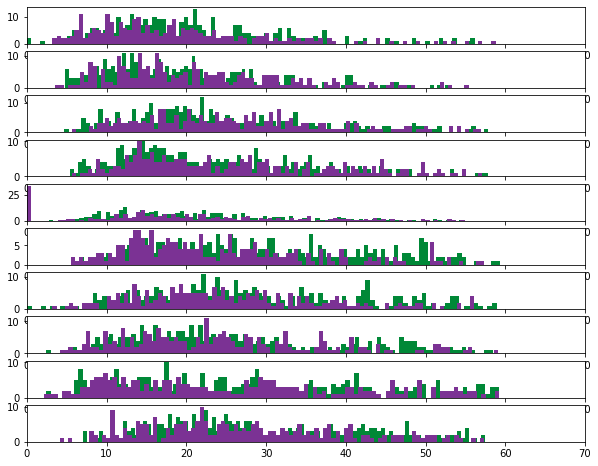

/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/ABIDE_FNC


In [30]:
'''
Statistical tests for Patients vs Controls 
'''

from scipy import stats
from scipy.stats import wilcoxon


saliency_id = 5

# ["peak", "median", "emd"]
for saliency_id in [5]:
    
    for metric in ["emd"]:
        
        HC_data = []
        PT_data = []
        
        ttest_counter = 0
        wilcox_counter = 0
            
        fig=plt.figure(figsize=(10,8))

        for restart in range(10):  # Trials

            predictions_file = os.path.join(basename, prefix+'_labels_save_'+str(restart)+'.npy')

            predictions = np.load(predictions_file)

            print("Predictions Shape:", predictions.shape)

        #     filename1 = os.path.join(basename, prefix+'_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')
            filename1 = os.path.join(basename, prefix+'_chk_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')

            print('Loaded saliency from...', filename1)
            Map1 = np.load(filename1)
            print(Map1.shape)


            Map1 = stitch_windows(Map1, components, samples_per_subject, sample_y, time_points, ws=window_shift)
            print('Average Shape:', Map1.shape)


        #     It ensures that while creating feature_ranking mask, the zero values will be treated separately 

            epsilon = 0.000000001
            Map1[Map1 == 0] = Map1[Map1 == 0] + epsilon

            sal_map = Map1 / np.max(Map1)
            sal_map = torch.from_numpy(sal_map).float()


            Map1 = torch.from_numpy(Map1).float()

            for f in range(len(Fraction)):

            # Remove data based on feature ranking and receive the updated data 

                Data = np.zeros(finalData.shape)

                data_mask = np.zeros(finalData.shape)
                feature_rank = np.zeros(finalData.shape)

                component_counter = np.zeros((finalData.shape[0], 53))

                # For revised data for saliency interpretation

                dCorrM1 = np.zeros((finalData.shape[0], 53, 53))  # Dynamic correlation matrices for all subjects. 
                dCorrM2 = np.zeros((finalData.shape[0], 53, 53))  # Dynamic correlation matrices for all subjects. 

                TP, TN, FP, FN = [], [], [], []

        #         template = np.zeros(140)+ 0.0001

                for t in range(Map1.shape[0]):
                    Data[t], feature_rank[t]= compute_RAR_feature_ranking(finalData[t], Map1[t], Fraction[f])

                    Data[t] = Data[t]/np.max(Data[t])

                    result = np.where(Data[t] != 0.0)

                    times = np.unique(result[1])  # Working on important time steps

                    data_mask[t][feature_rank[t] !=0] = 1 

                    component_counter[t, :] = np.sum(data_mask[t], axis=1)
                    component_counter[t] = component_counter[t, comp_indices]

                    map_to_fnc = Map1[t, comp_indices, :]*data_mask[t, comp_indices, :]

                    map_to_fnc = map_to_fnc / torch.max(map_to_fnc)
                    Data[t] = Data[t, comp_indices, :]
                    data_mask[t] = data_mask[t, comp_indices, :]
                    prod = (torch.from_numpy(Data[t]).float())*map_to_fnc
                    data_imp_temp = Data[t][:, times]      # RAR 5%
        #             dCorrM1[t, :, :] = dFNC(data_imp_temp)

                    if len(np.unique(Map1[t])) == 1:
                        temporal_count = np.array([1.0/Map1[t].shape[1]]*Map1[t].shape[1])
                    else:
                        temporal_count = np.sum(data_mask[t],0)

                    if int(Labels[t]) == int(predictions[t, 1]):

                        if int(Labels[t]) == 0:
                            TN.append(temporal_count)
                        else:
                            TP.append(temporal_count)

                    else:
                        if int(Labels[t]) == 0:
                            FP.append(temporal_count)
                        else:
                            FN.append(temporal_count)

                counter = 1
                my_dict = {"TP" : TP, "TN": TN, "FP": FP, "FN": FN}

                patients = []

                controls = []

                template = np.array([1.0/140]*140)

                for k, v in my_dict.items():
                    group = v
                    
                    if metric == "peak":
                        var = [np.argsort(x)[-1] for x in group]
                        
        #             median_locations = [np.argsort(x)[len(x)//2] for x in group]

                    elif metric == "median":
                        var = [np.argsort(x)[-(np.count_nonzero(x)//2)] for x in group]
        #             sort_by_locations = np.argsort(peak_locations)

                    elif metric == "emd":
                        x_interp = np.linspace(1, finalData.shape[2], 140)
                        xp = np.linspace(1, finalData.shape[2], finalData.shape[2])
                        new_group = [np.interp(x_interp, xp, fp) for fp in group]
                        var = [emd(x, template) for x in new_group]
                        
                    if k in ["TN", "FP"]:
                        controls.extend(var)
                    else:
                        patients.extend(var)


                print("Patients Size:", len(patients))
                print("Control Size:", len(controls))
                
                HC_data.extend(controls)
                PT_data.extend(patients)
                


#                 ax = plt.subplot(10, 2, (restart+1)*2 - 1)
                
                ax = plt.subplot(10, 1, restart+1)
                plt.hist(patients, bins=100, linewidth=0.5, color="#008837")
                plt.xlim(0, 70)

#                 if restart == 0:
#                     ax.set_title("Patients")

        #         ax.set_xticks([])
        #         ax.set_yticks([])

#                 ax = plt.subplot(10, 2, (restart+1)*2)
                plt.hist(controls, bins=100, linewidth = 0.5, color="#7b3294")
                plt.xlim(0, 70)


#                 if restart == 0:
#                     ax.set_title("Controls")

        #         ax.set_xticks([])
        #         ax.set_yticks([])


                t2, p2 = stats.ttest_ind(patients,controls)

                print("Test Results:", t2, p2)
                if p2 < 0.05:
                    ttest_counter += 1


                w, p = wilcoxon(patients[:len(controls)], controls)

                if p <= 0.05:
                    wilcox_counter += 1
                    

                print(f"Metric Used: {metric}, t-Tests: {ttest_counter}, wilcoxon tests: {wilcox_counter}")

                path = os.path.join(sbpath, Directories[Dataset[data]], dir, 'Maps')
        
        print("HC length:", len(HC_data))
        print("PT length:", len(PT_data))
        
        distributions = {'HC': HC_data, 'PT': PT_data[:len(HC_data)]}
        
        distributions = pd.DataFrame.from_dict(distributions)
        
        print(distributions)
        
        distribution_file = 'Sep_15_'+Dataset[data]+'_stability_sig_adjusted_'+metric+'_distributions_'+saliency_options[saliency_id]+'.csv'
        
        distributions.to_csv(distribution_file)
        
        print(f"File saved here {distribution_file}")
        
        f = 'Sep_15_'+Dataset[data]+'_stability_sig_adjusted_'+metric+'_hist_reproduced_'+saliency_options[saliency_id]+'.pdf'
        
        plt.savefig(f, format='pdf', dpi=600)
        print(f"File saved here {f}")
        plt.show()
        plt.close()
        print(os.getcwd())
    

# Load all datasets

In [ ]:
'''
This is for disease pair-wise tests
'''

import sys
import time


import numpy as np
import torch
import tkinter
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# import seaborn as sb
import seaborn as sns

import datetime
import os
from scipy import stats
from scipy.stats import wilcoxon

import pandas as pd

import random
import h5py
import time

from myscripts.LoadRealData import LoadABIDE, LoadCOBRE, LoadFBIRN, LoadOASIS
from myscripts.stitchWindows import stitch_windows
from datetime import datetime

from roar_utils import rescale_two, rescale_input, compute_feature_ranking, random_feature_ranking, compute_feature_ranking_double_ended, weighted_feature_ranking_double_ended, compute_RAR_feature_ranking, random_perm_RAR_feature_ranking

from myscripts.interpretation_utilities import plot_dfnc, plot_average_dfnc, plot_pattern, plot_binary_mask, plot_avg_pattern, do_t_test

%matplotlib inline
  

ensembles = {0:'', 1:'smoothgrad', 2:'smoothgrad_sq', 3: 'vargrad', 4:'', 5:'smoothgrad', 6:'smoothgrad_sq', 7: 'vargrad'}

saliency_options = {0:'Grad', 1:'SGGrad', 2: 'SGSQGrad', 3: 'VGGrad', 4: 'IG', 5: 'SGIG', 6:'SGSQIG', 7:'VGIG', 8: 'DLift', 9: 'DLiftShap', 10: 'ShapValSample', 11: 'ShapVal', 12: 'lime'}


start_time = time.time()


def find_indices_of_each_class(all_labels):
    HC_index = (all_labels == 0).nonzero()
    SZ_index = (all_labels == 1).nonzero()

    return HC_index, SZ_index

def ReLU(x):
    print("Greetings from ReLU")
    return x * (x >= 0)

def dFNC(data):
       
    M = np.corrcoef(data) 
    M = np.nan_to_num(M)
      
    return M 


MODELS = {0: 'FPT', 1: 'UFPT', 2: 'NPT'}

Dataset = {0: 'FBIRN', 1: 'COBRE', 2: 'OASIS', 3: 'ABIDE'}
Directories = { 'COBRE': 'COBRESaliencies','FBIRN' : 'FBIRNSaliencies', 'ABIDE' : 'ABIDESaliencies','OASIS' : 'OASISSaliencies'}

FNCDict = {"FBIRN": LoadFBIRN, "COBRE": LoadCOBRE, "OASIS": LoadOASIS, "ABIDE": LoadABIDE}

Params = {'FBIRN':[311, 140, 121], 'COBRE': [157, 140, 121], 'OASIS': [372, 120, 101], 'ABIDE': [569, 140, 121]}
train_lim = { 'FBIRN': 250, 'COBRE': 100, 'OASIS': 300, 'ABIDE': 400}

Params_subj_distr = { 'FBIRN': [15, 25, 50, 75, 100], 'COBRE': [15, 25, 40], 'OASIS': [15, 25, 50, 75, 100, 120], 'ABIDE': [15, 25, 50, 75, 100, 150]}

test_lim_per_class = { 'FBIRN': 32, 'COBRE': 15, 'OASIS': 32, 'ABIDE': 50}

# These gains were based on cross-validation based search

# Params_best_gains = {1: {'FBIRN': {'NPT':[1.0, 0.9, 0.9, 1.0, 1.0], 'UFPT': [1.0, 0.8, 0.7, 0.5, 0.4]}, 'OASIS': {'NPT': [0.9, 0.9, 1.0, 1.1, 1.1, 1.0], 'UFPT': [0.8, 0.8, 0.4, 0.3, 0.5, 0.4]}, 'ABIDE': {'NPT': [1.0, 0.9, 0.9, 1.0, 0.7, 0.6], 'UFPT': [0.4, 0.8, 0.3, 0.2, 0.2, 0.1]}, 'COBRE': {'NPT': [1.1, 0.7, 0.8], 'UFPT': [1.6, 1.3, 1.3]}}, 
#                      10: {'COBRE': {'NPT': [0.9, 0.9, 1.0], 'UFPT': [1.2, 1.2, 1.4]}},
#                      20: {'COBRE': {'NPT': [1.5, 0.8, 0.8], 'UFPT': [1.2, 1.3, 1.3]}}  
#                     }

# Revised h_fixed Simiple Gain Selection

Params_best_gains = {1: {'FBIRN': {'NPT':[1.2, 1.3, 0.7, 1.1, 0.9], 'UFPT': [0.9, 0.7, 0.6, 0.5, 0.4]}, 'ABIDE': {'NPT': [1.3, 1.3, 1.1, 0.9, 1.3, 0.6], 'UFPT': [0.4, 0.6, 0.5, 0.5, 0.3, 1.2]}, 'OASIS': {'NPT': [0.1, 1.2, 1.0, 1.0, 1.2, 0.7], 'UFPT': [0.7, 0.7, 1.3, 0.6, 1.1, 1.2]},'COBRE': {'NPT': [0.9, 0.9, 1.0], 'UFPT': [0.4, 1.1, 1.3]}}, 20: {'COBRE': {'NPT': [0.6, 1.1, 1.1], 'UFPT': [1.1, 1.5, 0.6]}}}

mode = 1  # Choose FPT (0) / UFPT (1) / NPT (2)

finalData = {}
FNC = {}
Labels = {}
prefixes = {}
time_points = {}
HC_index = {}
PT_index = {}

Trials = 10
np.random.seed(0)


for data in [0, 2, 3]: # Choose FBIRN (0)/ COBRE (1) / OASIS (2) / ABIDE (3) 

    finalData[Dataset[data]], FNC[Dataset[data]], Labels[Dataset[data]] = FNCDict[Dataset[data]]()

    print('Final Data Shape:', finalData[Dataset[data]].shape)
    print('FNC shape:', FNC[Dataset[data]].shape)

    HC_index[Dataset[data]], PT_index[Dataset[data]] = find_indices_of_each_class(Labels[Dataset[data]])

    print('Length of HC:', len(HC_index[Dataset[data]]))
    print('Length of PT:', len(PT_index[Dataset[data]]))

    print('HC_index:', HC_index[Dataset[data]].shape)
    print('SZ_index:', PT_index[Dataset[data]].shape)

    HC_index[Dataset[data]] = np.squeeze(HC_index[Dataset[data]], axis = 1)
    PT_index[Dataset[data]] = np.squeeze(PT_index[Dataset[data]], axis = 1)
    print('HC_index:', HC_index[Dataset[data]].shape)

    components = finalData[Dataset[data]].shape[1]
    sample_y = 20
    subjects = Params[Dataset[data]][0]
    time_points[Dataset[data]] = Params[Dataset[data]][1]
    samples_per_subject = Params[Dataset[data]][2]
    window_shift = 1

    dir = MODELS[mode]   # NPT or UFPT
    print(os.getcwd())
    root_path = "/data/users2/mrahman21/Saliency/myscripts"
    os.chdir(root_path)

    filename = 'transform_to_correct_GSP.csv'
    print(filename)
    df = pd.read_csv(filename, header=None)
    c_indices = df.values
    c_indices = c_indices - 1
    # c_indices = torch.from_numpy(c_indices).int()
    comp_indices = c_indices[:, 2]  # Third column in the file contains the transformation indices...
    # comp_indices = comp_indices.int()

    run_dir = "../wandb/Classic_ML_Models/"+Dataset[data]+"_FNC"

    os.chdir(run_dir)   # Dynamically change the current directory during run time.
    print(os.getcwd())

    sbpath = os.path.join('../../', 'Sequence_Based_Models')

    subjects_per_group = Params_subj_distr[Dataset[data]] 

    Best_gain = Params_best_gains[window_shift][Dataset[data]][MODELS[mode]]
    print('Best Gain Chosen:', Best_gain)


    finalData[Dataset[data]] = torch.from_numpy(finalData[Dataset[data]]).float()

    Fraction = [0.05] #[0.05, 0.1, 0.2, 0.3] 


    i = len(subjects_per_group) - 1
    g = Best_gain[i]

    last_test_fold_id = {'FBIRN': 4, 'OASIS': 5, 'ABIDE': 4}
    test_ID = last_test_fold_id[Dataset[data]]

    # prefix = Dataset[data]+'_spc_'+str(subjects_per_group[i])+'_cross_val_gain_'+str(g)+'_'+dir+'_LSTM_milc'

    prefixes[Dataset[data]]= f'{Dataset[data]}_spc_{subjects_per_group[i]}_simple_gain_{g}_window_shift_{window_shift}_{dir}_stab_sig_rmv_chk_h_test_id_{test_ID}_LSTM_milc'

    # prefix= f'{Dataset[data]}_spc_{subjects_per_group[i]}_simple_gain_{g}_window_shift_{window_shift}_{dir}_arch_chk_h_fixed_test_id_{test_ID}_LSTM_milc'

    Labels[Dataset[data]] = Labels[Dataset[data]].numpy()

    print("Basic loading Done...")


# Run disease-pair tests

In [ ]:
'''
This is for disease-pair tests
'''

data1 = 2
data2 = 3

# ["peak", "median", "emd"]
for saliency_id in [5]:
    
    for metric in ["emd"]:
        
        disorder1_data = []
        disorder2_data = []
        
        ttest_counter = 0
        wilcox_counter = 0
              
        fig=plt.figure(figsize=(10,8))

        for restart in range(10):  # Trials
            
            basename1 = os.path.join(sbpath, Directories[Dataset[data1]], dir, 'Saliency')
            prefix1 = prefixes[Dataset[data1]]
            
            basename2 = os.path.join(sbpath, Directories[Dataset[data2]], dir, 'Saliency')
            prefix2 = prefixes[Dataset[data2]]

            predictions_file1 = os.path.join(basename1, prefix1+'_labels_save_'+str(restart)+'.npy')
            predictions1 = np.load(predictions_file1)
            print(f"Predictions Shape:{predictions1.shape}")
            
            
            predictions_file2 = os.path.join(basename2, prefix2+'_labels_save_'+str(restart)+'.npy')
            predictions2 = np.load(predictions_file2)
            print(f"Predictions Shape:{predictions2.shape}")
            

        #     filename1 = os.path.join(basename, prefix+'_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')
            filename1 = os.path.join(basename1, prefix1+'_chk_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')
            filename2 = os.path.join(basename2, prefix2+'_chk_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')

            
            # For Dataset 1
            print('Loaded saliency from...', filename1)
            Map1 = np.load(filename1)
            print(Map1.shape)


            Map1 = stitch_windows(Map1, components, samples_per_subject, sample_y, time_points[Dataset[data1]], ws=window_shift)
            print('Average Shape:', Map1.shape)


        #     It ensures that while creating feature_ranking mask, the zero values will be treated separately 

            epsilon = 0.000000001
            Map1[Map1 == 0] = Map1[Map1 == 0] + epsilon

            sal_map1 = Map1 / np.max(Map1)
            sal_map1 = torch.from_numpy(sal_map1).float()

            Map1 = torch.from_numpy(Map1).float()
            
            # For Dataset 2
            print('Loaded saliency from...', filename2)
            Map2 = np.load(filename2)
            print(Map2.shape)


            Map2 = stitch_windows(Map2, components, samples_per_subject, sample_y, time_points[Dataset[data2]], ws=window_shift)
            print('Average Shape:', Map2.shape)


        #     It ensures that while creating feature_ranking mask, the zero values will be treated separately 

            epsilon = 0.000000001
            Map2[Map2 == 0] = Map2[Map2 == 0] + epsilon

            sal_map2 = Map2 / np.max(Map2)
            sal_map2 = torch.from_numpy(sal_map2).float()

            Map2 = torch.from_numpy(Map2).float()


            for f in range(len(Fraction)):

            # Remove data based on feature ranking and receive the updated data 

                Data1 = np.zeros(finalData[Dataset[data1]].shape)

                data_mask1 = np.zeros(finalData[Dataset[data1]].shape)
                
                Data2 = np.zeros(finalData[Dataset[data2]].shape)

                data_mask2 = np.zeros(finalData[Dataset[data2]].shape)

                prediction_details_dict = {}
                
                TP, TN, FP, FN = [], [], [], []

                for t in range(Map1.shape[0]):
                    Data1[t] = compute_RAR_feature_ranking(finalData[Dataset[data1]][t], Map1[t], Fraction[f])

                    Data1[t] = Data1[t]/np.max(Data1[t])

                    data_mask1[t][Data1[t] !=0] = 1 

                    data_mask1[t] = data_mask1[t, comp_indices, :]
                    

                    if int(Labels[Dataset[data1]][t]) == int(predictions1[t, 1]):

                        if int(Labels[Dataset[data1]][t]) == 0:
                            TN.append(np.sum(data_mask1[t],0))
                        else:
                            TP.append(np.sum(data_mask1[t],0))

                    else:
                        if int(Labels[Dataset[data1]][t]) == 0:
                            FP.append(np.sum(data_mask1[t],0))
                        else:
                            FN.append(np.sum(data_mask1[t],0))


                prediction_details_dict[Dataset[data1]] = {"TP" : TP, "TN": TN, "FP": FP, "FN": FN}
                
                
                TP, TN, FP, FN = [], [], [], []

                for t in range(Map2.shape[0]):
                    Data2[t] = compute_RAR_feature_ranking(finalData[Dataset[data2]][t], Map2[t], Fraction[f])

                    Data2[t] = Data2[t]/np.max(Data2[t])

                    data_mask2[t][Data2[t] !=0] = 1 

                    data_mask2[t] = data_mask2[t, comp_indices, :]
                    

                    if int(Labels[Dataset[data2]][t]) == int(predictions2[t, 1]):

                        if int(Labels[Dataset[data2]][t]) == 0:
                            TN.append(np.sum(data_mask2[t],0))
                        else:
                            TP.append(np.sum(data_mask2[t],0))

                    else:
                        if int(Labels[Dataset[data2]][t]) == 0:
                            FP.append(np.sum(data_mask2[t],0))
                        else:
                            FN.append(np.sum(data_mask2[t],0))

                
                prediction_details_dict[Dataset[data2]] = {"TP" : TP, "TN": TN, "FP": FP, "FN": FN}
                
                patient_n_controls = {}
                
                larger_time_points = max(finalData[Dataset[data1]].shape[2], finalData[Dataset[data2]].shape[2])
                print("Larger time points:", larger_time_points)
                
                for dataset_name, predict_dict in prediction_details_dict.items():
                    patients = []
                    controls = []

                    template = np.array([1/larger_time_points]*larger_time_points)
                    
                    my_dict = predict_dict

                    for k, v in my_dict.items():
                        group = v

                        if metric == "peak":
                            var = [np.argsort(x)[-1] for x in group]

            #             median_locations = [np.argsort(x)[len(x)//2] for x in group]

                        elif metric == "median":
                            var = [np.argsort(x)[-(np.count_nonzero(x)//2)] for x in group]
            #             sort_by_locations = np.argsort(peak_locations)

                        elif metric == "emd":
                            x_interp = np.linspace(1, finalData[dataset_name].shape[2], larger_time_points)
                            xp = np.linspace(1, finalData[dataset_name].shape[2], finalData[dataset_name].shape[2])
                            new_group = [np.interp(x_interp, xp, fp) for fp in group]
                            var = [emd(x, template) for x in new_group]
#                             var = map(lambda x: x/finalData[dataset_name].shape[2], var)

                        if k in ["TN", "FP"]:
                            controls.extend(var)
                        else:
                            patients.extend(var)
                    
                    patient_n_controls[dataset_name+"_patients"] = patients 
                    patient_n_controls[dataset_name+"_controls"] = controls 


                    print("Patients Size:", len(patients))
                    print("Control Size:", len(controls))

                
                disorder1 = patient_n_controls[Dataset[data1]+"_patients"] 
                disorder2 = patient_n_controls[Dataset[data2]+"_patients"] 
                
                print(f"Disorder 1: {Dataset[data1]}, Size:{len(disorder1)}")
                print(f"Disorder 2: {Dataset[data2]}, Size:{len(disorder2)}")
                
                disorder1_data.extend(disorder1)
                disorder2_data.extend(disorder2)
                
                
#                 ax = plt.subplot(10, 2, (restart+1)*2 - 1)
                
                ax = plt.subplot(10, 1, restart+1)
                plt.hist(disorder1, bins=100, linewidth=0.5, color="#008837", label=Dataset[data1])
                plt.xlim(0, 70)

#                 if restart == 0:
#                     ax.set_title("Patients")

                ax.set_xticks([])
                ax.set_yticks([])

#                 ax = plt.subplot(10, 2, (restart+1)*2)
                plt.hist(disorder2, bins=100, linewidth = 0.5, color="#7b3294", label=Dataset[data2])
                plt.xlim(0, 70)

#                 if restart == 0:
#                     ax.set_title("Controls")

                ax.set_xticks([])
                ax.set_yticks([])
                
                if restart == 9:
                    plt.legend(loc="upper right")
            
                plt.suptitle(f"{Dataset[data1]} vs {Dataset[data2]}")
        

                t2, p2 = stats.ttest_ind(disorder1, disorder2)

                print("Test Results:", t2, p2)
                if p2 < 0.05:
                    ttest_counter += 1
                    plt.ylabel("t-YES", color = "red")


                w, p = wilcoxon(disorder1, disorder2[:len(disorder1)])

                if p <= 0.05:
                    wilcox_counter += 1
#                     plt.xlabel("w-YES", color = "red")


                print(f"Metric Used: {metric}, t-Tests: {ttest_counter}, wilcoxon tests: {wilcox_counter}")
                
                run_dir = "../wandb/Classic_ML_Models/"+Dataset[data1]+"_FNC"

#                 os.chdir(run_dir)
        
        print("Disorder 1 length:", len(disorder1_data))
        print("Disorder 2 length:", len(disorder2_data))
        
        sample2 = disorder2_data[:len(disorder1_data)]
        
#         sample2 = random.sample(disorder2_data, len(disorder1_data))
        distributions = {Dataset[data1]: disorder1_data, Dataset[data2]: sample2}
        
        t2, p2 = stats.ttest_ind(disorder1_data, sample2)

        print("Test Results:", t2, p2)
        if p2 < 0.05:
            print('Merge result t-test passed')
            
        w, p = wilcoxon(disorder1_data, sample2)
        
        print("Test Results:", p)

        if p <= 0.05:
            print('Merge result wilcoxon-test passed')

        distributions = pd.DataFrame.from_dict(distributions)
        
        print(distributions)
        
        distribution_file = f"Sep_13_sig_rmv_{Dataset[data1]}_vs_{Dataset[data2]}_stability_{metric}_distributions_{saliency_options[saliency_id]}.csv"
        
        
        distributions.to_csv(distribution_file)
        print(f"File saved here: {distribution_file}")
        
        f = f"Sep_13_Stability_sig_rmv_{metric}_hist_{Dataset[data1]}_vs_{Dataset[data2]}_{saliency_options[saliency_id]}.pdf"
        
        save_loc = os.path.join("../", f) 
        
        plt.savefig(save_loc, format='pdf', dpi=600)
        print(f"File saved here {save_loc}")
        plt.show()
        plt.close()
        print(os.getcwd())

elapsed_time = time.time() - start_time
print('Total Time Elapsed:', elapsed_time)
print(datetime.now())

# FNC Calculations for All Datasets

In [ ]:
Fraction = [1.0] #[0.05, 0.1, 0.2, 0.3] 
FNC05_dict = {}

for saliency_id in [4]:
    
    for data in [0, 2, 3]:

        for restart in range(1):  # Trials
            
            basename = os.path.join(sbpath, Directories[Dataset[data]], dir, 'Saliency')
            prefix = prefixes[Dataset[data]]
            
            predictions_file = os.path.join(basename, prefix+'_labels_save_'+str(restart)+'.npy')
            predictions = np.load(predictions_file)
            print(f"Predictions Shape:{predictions.shape}")
            

        #     filename1 = os.path.join(basename, prefix+'_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')
            filename1 = os.path.join(basename, prefix+'_chk_prediction_'+saliency_options[saliency_id]+'_'+str(restart)+'.npy')
           
            
            # For Dataset 1
            print('Loaded saliency from...', filename1)
            Map1 = np.load(filename1)
            print(Map1.shape)


            Map1 = stitch_windows(Map1, components, samples_per_subject, sample_y, time_points[Dataset[data]], ws=window_shift)
            print('Average Shape:', Map1.shape)


        #     It ensures that while creating feature_ranking mask, the zero values will be treated separately 

            epsilon = 0.000000001
            Map1[Map1 == 0] = Map1[Map1 == 0] + epsilon

            sal_map1 = Map1 / np.max(Map1)
            sal_map1 = torch.from_numpy(sal_map1).float()

            Map1 = torch.from_numpy(Map1).float()

            for f in range(len(Fraction)):

            # Remove data based on feature ranking and receive the updated data 

                Data = np.zeros(finalData[Dataset[data]].shape)

                data_mask = np.zeros(finalData[Dataset[data]].shape)
                
                dCorrM = np.zeros((finalData[Dataset[data]].shape[0], 53, 53))  # Dynamic correlation matrices for all subjects. 

                for t in range(Map1.shape[0]):
                    Data[t] = compute_RAR_feature_ranking(finalData[Dataset[data]][t], Map1[t], Fraction[f])

                    Data[t] = Data[t]/np.max(Data[t])
                    
                    result = np.where(Data[t] != 0.0)

                    times = np.unique(result[1])  # Working on important time steps

                    data_mask[t][Data[t] !=0] = 1 

                    map_to_fnc = Map1[t, comp_indices, :]*data_mask[t, comp_indices, :]
                    map_to_fnc = map_to_fnc / torch.max(map_to_fnc)
                    Data[t] = Data[t, comp_indices, :]
                    data_mask[t] = data_mask[t, comp_indices, :]
                    prod = (torch.from_numpy(Data[t]).float())*map_to_fnc
                    data_imp_temp = Data[t][:, times]      # RAR 5%
                    dCorrM[t, :, :] = dFNC(data_imp_temp)
                    

            PT_n_HC = {}

#             PT_n_HC["patients"]=dCorrM[PT_index[Dataset[data]], :, :]

#             PT_n_HC["controls"] =dCorrM[HC_index[Dataset[data]], :, :]

            X_PT = Data[PT_index[Dataset[data]]]
            print("Patient Shape:", X_PT.shape)
            a = X_PT[0]
            for q in range(1, X_PT.shape[0]):
                a = np.concatenate((a, X_PT[q]), axis=1)
            print("Concatenated Shape:", a.shape)

            patient_fnc_result = dFNC(a)

            PT_n_HC["patients"] = patient_fnc_result


            X_HC = Data[HC_index[Dataset[data]]]
            print("Controls Shape:", X_HC.shape)
            b = X_HC[0]
            for q in range(1, X_HC.shape[0]):
                b = np.concatenate((b, X_HC[q]), axis=1)
            print("Concatenated Shape:", b.shape)

            controls_fnc_result = dFNC(b)

            PT_n_HC["controls"] = controls_fnc_result
            
            FNC05_dict[Dataset[data]] = PT_n_HC

            path = os.path.join(sbpath, Directories[Dataset[data]], dir, 'Maps')

#             Plot group-wise FNC at different % 

            for k, v in PT_n_HC.items():
                
                pattern_filename = f"{prefix}_{saliency_options[saliency_id]}_MOD_{restart}_frac_{Fraction[f]}_percent_{k}_data_fnc_Aug_31_for_draft"
                group_wise_sfnc_path = os.path.join(path, pattern_filename)
                print(group_wise_sfnc_path)

                plt.figure(figsize=(10,5))
                fnc_plot(v, group_wise_sfnc_path, clim=(-0.6, 0.6))

                np.save(group_wise_sfnc_path, v)


In [ ]:
import numpy as np
import pylab as plt

DIR = '/Users/splis/Documents/papers/mypapers/transfer_fmri/NatureComm/code/Data_FNC_matrices/'
OASIS05 = np.load(DIR+'OASIS_spc_120_cross_val_gain_0.4_UFPT_LSTM_milc_SGSQIG_MOD_8_frac_0.05_percent_group_wise_data_fnc_mat_for_draft.npy')
FBIRN05 = np.load(DIR+'FBIRN_spc_100_cross_val_gain_0.4_UFPT_LSTM_milc_SGSQIG_MOD_8_frac_0.05_percent_group_wise_data_fnc_mat_for_draft.npy')
ABIDE05 = np.load(DIR+'ABIDE_spc_150_cross_val_gain_0.1_UFPT_LSTM_milc_SGSQIG_MOD_8_frac_0.05_percent_group_wise_data_fnc_mat_for_draft.npy')

np.fill_diagonal(OASIS05, 0)
np.fill_diagonal(FBIRN05, 0)
np.fill_diagonal(ABIDE05, 0)


def plot_my_fnc(M, title, clim=(-1,1)):
    plt.imshow(M, interpolation=None, clim=clim,
               cmap=plt.cm.seismic)
    ax = plt.gca()
    plt.title(title)
    plt.colorbar()
    # Minor ticks
    groups = [-0.5, 4.5, 6.5, 15.5, 24.5, 41.5, 48.5, 52.5]
    ax.set_xticks(groups, minor=True)
    ax.set_yticks(groups, minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
    # Major ticks
    group_centers = [2, 5.5, 11, 20, 33, 45, 50.5]
    ax.set_xticks(group_centers)
    ax.set_yticks(group_centers)

    # Labels for major ticks
    labels = ['SC', 'AU', 'SM', 'VI', 'CC', 'DM', 'CB']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=90, fontdict={'verticalalignment': 'center'})
    ax.tick_params(axis='both', which='major', length=0)
    #ax.set_frame_on(False)
    plt.savefig(title+'.svg', transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()


plt.figure(figsize=(10,5))
fnc_plot(FBIRN05, 'FBIRN', clim=(-0.6, 0.6))
plt.figure(figsize=(10,5))
fnc_plot(ABIDE05, 'ABIDE', clim=(-0.6, 0.6))
plt.figure(figsize=(10,5))
fnc_plot(OASIS05, 'OASIS', clim=(-0.6, 0.6))

plt.figure(figsize=(10,5))
ABIDE = FBIRN05-OASIS05
fnc_plot(ABIDE, 'FBIRN-OASIS', clim=(-0.25, 0.25))

plt.figure(figsize=(10,5))
OASIS = OASIS05-ABIDE05
fnc_plot(OASIS, 'OASIS-ABIDE', clim=(-0.25, 0.25))

plt.figure(figsize=(10,5))
FBIRN = FBIRN05-ABIDE05
fnc_plot(FBIRN, 'FBIRN-ABIDE', clim=(-0.25, 0.25))



In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# create data
values=np.random.uniform(size=40)
 
# plot without markers
plt.stem(values, markerfmt=' ')
plt.show()
 
# change color and shape and size and edges
(markers, stemlines, baseline) = plt.stem(values)
plt.setp(markers, marker='D', markersize=10, markeredgecolor="orange", markeredgewidth=2)
plt.show()


In [ ]:
import numpy as np
import torch
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sb

import random 
%matplotlib inline

randomlist = random.sample(range(10, 300), 100)
print(randomlist)
plt.stem(randomlist)

In [ ]:
print("Motivated")

In [ ]:
TP, TN, FP, FN = [], [], [], []
print(TP)
print(FN)
print(TN)

In [ ]:
import numpy as np


print(a)

In [ ]:
a = normalize(a)
print(a)

In [ ]:
a = np.array([0, 0, 0, 1, 1, 2, 3, 4, 0, 7, 0, 0])
print(np.count_nonzero(a))
print(np.sort(a))
print(np.argsort(a))

# Customizing KL-divergence code for fitting our data.

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt


class GaussianMixture1D:
    def __init__(self, mixture_probs, means, stds):
        self.num_mixtures = len(mixture_probs)
        self.mixture_probs = mixture_probs
        self.means = means
        self.stds = stds

    def sample(self, num_samples=1):
        mixture_ids = np.random.choice(self.num_mixtures, size=num_samples, p=self.mixture_probs)
        result = np.zeros([num_samples])
        for sample_idx in range(num_samples):
            result[sample_idx] = np.random.normal(
                loc=self.means[mixture_ids[sample_idx]],
                scale=self.stds[mixture_ids[sample_idx]]
            )
        return result

    def logpdf(self, samples):
        mixture_logpdfs = np.zeros([len(samples), self.num_mixtures])
        for mixture_idx in range(self.num_mixtures):
            mixture_logpdfs[:, mixture_idx] = scipy.stats.norm.logpdf(
                samples,
                loc=self.means[mixture_idx],
                scale=self.stds[mixture_idx]
            )
        return sp.special.logsumexp(mixture_logpdfs + np.log(self.mixture_probs), axis=1)

    def pdf(self, samples):
        return np.exp(self.logpdf(samples))


def approx_forward_kl(p_true, gmm_q, xs): 
    ys =  p_true*(p_true - gmm_q.logpdf(xs))
    return np.trapz(ys, xs)

def approx_reverse_kl(gmm_q, p_true, xs):
    ys = gmm_q.pdf(xs) * (gmm_q.logpdf(xs) - p_true)
    return np.trapz(ys, xs)


def minimize_pq(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_forward_kl(p, q, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def minimize_qp(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_reverse_kl(q, p, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def main():


    p = np.random.randint(54, size=(140,))
    
    p_dist = np.zeros(len(p))
    
    for i in range(len(p)):
        p_dist[i] = p[i]/ np.sum(p)
        
    print(p_dist)

    q_means_min = 0 
    q_means_max = 139 
    num_q_means = 20
    q_means = np.linspace(q_means_min, q_means_max, num_q_means)

    q_stds_min = 0.1
    q_stds_max = 5
    num_q_stds = 20
    q_stds = np.linspace(q_stds_min, q_stds_max, num_q_stds)

    num_trapz_points = 140
    trapz_xs = np.linspace(0, 139, num_trapz_points)

    q_best_forward, kl_best_forward = minimize_pq(
        p_dist, trapz_xs, q_means, q_stds
    )

    print(q_best_forward.means, kl_best_forward)
    q_best_reverse, kl_best_reverse = minimize_qp(
        p_dist, trapz_xs, q_means, q_stds
    )

    print(q_best_reverse.means, kl_best_reverse)
    print(q_best_reverse.sample(140))
    
    print(q_best_forward.sample(140))

    # plotting

    fig=plt.figure(figsize=(10,8))
    xs_min = 0
    xs_max = 139
    num_plot_points = 140
    xs = np.linspace(xs_min, xs_max, num_plot_points)
    plt.plot(xs, p_dist, label='$p$', color='red')
    plt.plot(xs, q_best_forward.pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(p || q)$', color='magenta', linestyle='dashed')
    plt.plot(xs, q_best_reverse.pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(q || p)$', color='green', linestyle='dotted')
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.axis('off')
    
    plt.show()

    filenames = ['reverse_forward_kl.pdf', 'reverse_forward_kl.png']
    for filename in filenames:
        fig.savefig(filename, bbox_inches='tight', dpi=200)
        print('Saved to {}'.format(filename))


if __name__ == '__main__':
    main()

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt


class GaussianMixture1D:
    def __init__(self, mixture_probs, means, stds):
        self.num_mixtures = len(mixture_probs)
        self.mixture_probs = mixture_probs
        self.means = means
        self.stds = stds

    def sample(self, num_samples=1):
        mixture_ids = np.random.choice(self.num_mixtures, size=num_samples, p=self.mixture_probs)
        result = np.zeros([num_samples])
        for sample_idx in range(num_samples):
            result[sample_idx] = np.random.normal(
                loc=self.means[mixture_ids[sample_idx]],
                scale=self.stds[mixture_ids[sample_idx]]
            )
        return result

    def logpdf(self, samples):
        mixture_logpdfs = np.zeros([len(samples), self.num_mixtures])
        for mixture_idx in range(self.num_mixtures):
            mixture_logpdfs[:, mixture_idx] = scipy.stats.norm.logpdf(
                samples,
                loc=self.means[mixture_idx],
                scale=self.stds[mixture_idx]
            )
        return sp.special.logsumexp(mixture_logpdfs + np.log(self.mixture_probs), axis=1)

    def pdf(self, samples):
        return np.exp(self.logpdf(samples))


def approx_kl(gmm_1, gmm_2, xs):
    ys = gmm_1.pdf(xs) * (gmm_1.logpdf(xs) - gmm_2.logpdf(xs))
    return np.trapz(ys, xs)


def minimize_pq(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(p, q, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def minimize_qp(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(q, p, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def main():
    p_second_means_min = 0
    p_second_means_max = 10
    num_p_second_means = 5
    p_second_mean_list = np.linspace(p_second_means_min, p_second_means_max, num_p_second_means)

    p = [None] * num_p_second_means
    q_best_forward = [None] * num_p_second_means
    kl_best_forward = [None] * num_p_second_means
    q_best_reverse = [None] * num_p_second_means
    kl_best_reverse = [None] * num_p_second_means

    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        p_mixture_probs = np.array([0.5, 0.5])
        p_means = np.array([0, p_second_mean])
        p_stds = np.array([1, 1])
        p[p_second_mean_idx] = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

        q_means_min = np.min(p_means) - 1
        q_means_max = np.max(p_means) + 1
        num_q_means = 20
        q_means = np.linspace(q_means_min, q_means_max, num_q_means)

        q_stds_min = 0.1
        q_stds_max = 5
        num_q_stds = 20
        q_stds = np.linspace(q_stds_min, q_stds_max, num_q_stds)

        trapz_xs_min = np.min(np.append(p_means, q_means_min)) - 3 * np.max(np.append(p_stds, q_stds_max))
        print(trapz_xs_min)
        trapz_xs_max = np.max(np.append(p_means, q_means_min)) + 3 * np.max(np.append(p_stds, q_stds_max))
        print(trapz_xs_max)
        num_trapz_points = 1000
        trapz_xs = np.linspace(trapz_xs_min, trapz_xs_max, num_trapz_points)

        q_best_forward[p_second_mean_idx], kl_best_forward[p_second_mean_idx] = minimize_pq(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )
        q_best_reverse[p_second_mean_idx], kl_best_reverse[p_second_mean_idx] = minimize_qp(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )

    # plotting
    fig, axs = plt.subplots(nrows=1, ncols=num_p_second_means, sharex=True, sharey=True)
    fig.set_size_inches(8, 1.5)
    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        xs_min = -5
        xs_max = 15
        num_plot_points = 1000
        xs = np.linspace(xs_min, xs_max, num_plot_points)
        axs[p_second_mean_idx].plot(xs, p[p_second_mean_idx].pdf(xs), label='$p$', color='black')
        axs[p_second_mean_idx].plot(xs, q_best_forward[p_second_mean_idx].pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(p || q)$', color='black', linestyle='dashed')
        axs[p_second_mean_idx].plot(xs, q_best_reverse[p_second_mean_idx].pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(q || p)$', color='black', linestyle='dotted')

        axs[p_second_mean_idx].spines['right'].set_visible(False)
        axs[p_second_mean_idx].spines['top'].set_visible(False)
        axs[p_second_mean_idx].set_yticks([])
        axs[p_second_mean_idx].set_xticks([])

    axs[2].legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize='small')
    filenames = ['reverse_forward_kl.pdf', 'reverse_forward_kl.png']
    for filename in filenames:
        fig.savefig(filename, bbox_inches='tight', dpi=200)
        print('Saved to {}'.format(filename))


if __name__ == '__main__':
    main()

In [ ]:
a = np.linspace(0, 139, 140)

In [ ]:
print(a)

In [ ]:
p = np.random.randint(54, size=(140,))
print(p)

var = np.count_nonzero(p == p[0])
print(var)

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns

fmri = sns.load_dataset("fmri")
print(fmri)

my_array = np.array([[11,20, 24, 21, 27, 33],[44,40, 48, 55,50, 66]])
print(my_array)

my_array = my_array.T
print(my_array)
df = pd.DataFrame(my_array)
print(df)

frames_all_series = []
for i in range(2):
    per_series = df[[i]]
    per_series.columns = ["Signal"]
    per_series.insert(1, "Timepoint", range(1, 7))
    frames_all_series.append(per_series)

new_df = pd.concat(frames_all_series, axis=0)

print(new_df)
# sns.lineplot(x="timepoint", y="signal",
#                  hue="region", style="event", err_style="bars", ci=68,
#                  data=fmri)

sns.lineplot(x="Timepoint", y="Signal", err_style="bars", ci=68,
                 data=new_df)

In [ ]:
from matplotlib import pyplot as pl
import numpy as np


x = np.linspace(0, 30, 100)
y = np.sin(x) * 0.5
pl.plot(x, y, '-k')


x = np.linspace(0, 30, 30)
y = np.sin(x/6*np.pi)
error = np.random.normal(0.1, 0.02, size=y.shape) +.1
y += np.random.normal(0, 0.1, size=y.shape)

pl.plot(x, y, 'k', color='#CC4F1B')
pl.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

y = np.cos(x/6*np.pi)    
error = np.random.rand(len(y)) * 0.5
y += np.random.normal(0, 0.1, size=y.shape)
pl.plot(x, y, 'k', color='#1B2ACC')
pl.fill_between(x, y-error, y+error,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)



y = np.cos(x/6*np.pi)  + np.sin(x/3*np.pi)  
error = np.random.rand(len(y)) * 0.5
y += np.random.normal(0, 0.1, size=y.shape)
pl.plot(x, y, 'k', color='#3F7F4C')
pl.fill_between(x, y-error, y+error,
    alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
    linewidth=0)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.return_types.topk(
values=tensor([1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.00

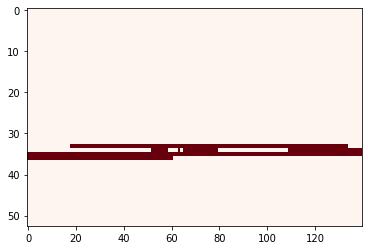

In [24]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

filename = os.path.join('/data/users2/mrahman21/Saliency/wandb/Classic_ML_Models/FBIRN_FNC/sample_7.npy')

A = np.load(filename)
print(A)
A[A == 0] = A[A == 0] + 1e-9

A = torch.from_numpy(A)

topk_values = torch.topk(A.view(-1), int(A.view(-1).shape[0] * 0.05))
feature_ranking = torch.zeros_like(A.view(-1))
feature_ranking[topk_values[1]] = A.view(-1)[topk_values[1]]
feature_ranking = feature_ranking.reshape(A.shape)
print(topk_values)

substitute_information = torch.zeros_like(A)
#     substitute_information = torch.fill_(substitute_information, torch.mean(input.float()))
substitute_information = torch.fill_(substitute_information, 0.0)

mask_information = torch.zeros_like(A)
mask_information = torch.fill_(mask_information, 1)

# Keep only the non zero marked entries because they are important as opposed to ROAR

new_data = torch.where(feature_ranking == 0, substitute_information, A)

binary_mask = np.zeros(A.shape)
new_data = new_data.numpy()
binary_mask[feature_ranking != 0] = 1

plt.imshow(feature_ranking, interpolation='nearest', aspect='auto', cmap= "Reds")
plt.show()